# 02 - Exploratory Analysis

In this step (pAce: Analyze Stage), we examin key patterns and relationships in the data to understand factors associated with employee attrition. This includes analyzing workload, satisfaction, promotions, departmental trends, and performance metrics to identify variables with potential influence on turnover.

### Import packages

In [22]:
# Import packages
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Set base directory 
base_dir = Path(os.getcwd()).parent

# Set default figure directory
fig_dir = base_dir / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

# Set matplotlib backend to PDF-friendly (optional, for consistent rendering)
plt.rcParams["pdf.fonttype"] = 42  # Ensures text is saved as text (not paths)
plt.rcParams["ps.fonttype"] = 42

### Load data

In [23]:
# Load the dataset
data_dir = base_dir / "data" 
data_file = data_dir / "processed" / "HR_capstone_dataset_no_outliers.csv"

# Read the cleaned CSV file into a pandas DataFrame
df_cleaned = pd.read_csv(data_file)

### Data Exploration


We begin by understanding how many employees left and what percentage of all employees this figure represents.

In [24]:
# Get numbers of people who left vs. stayed
left_count = df_cleaned['has_left_company'].value_counts()
print("Number of Employees who left vs. stayed:")
print(left_count)

# Get percentages of people who left vs. stayed
left_percentage = left_count / left_count.sum() * 100
print("\nPercentage of people who left vs. stayed:")
print(left_percentage)


Number of Employees who left vs. stayed:
has_left_company
Stayed    9285
Left      1882
Name: count, dtype: int64

Percentage of people who left vs. stayed:
has_left_company
Stayed    83.146772
Left      16.853228
Name: count, dtype: float64


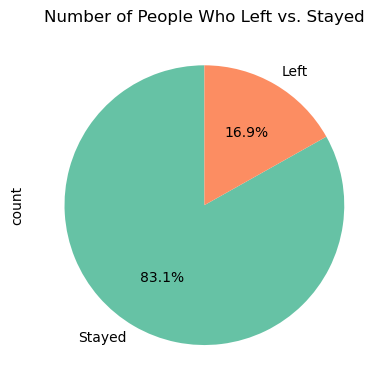

In [25]:
# Plot the number of people who left vs. stayed as pie chart
plt.figure(figsize=(6, 4))
df_cleaned['has_left_company'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
plt.title('Number of People Who Left vs. Stayed')
plt.tight_layout()
plt.savefig(fig_dir / 'left_vs_stayed.pdf')
plt.show()

We observe that approximately **~17% of employees** have left.  
Unfortunately, we don't have temporal data at this stage, which would inform whether there has been an increase or decrease in attrition over time.

Next we will look at the distribution of all the categorical variables in the dataset. To that end, we will plot histograms for each variable

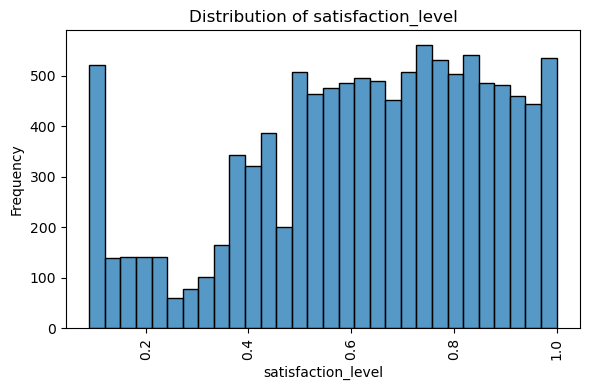

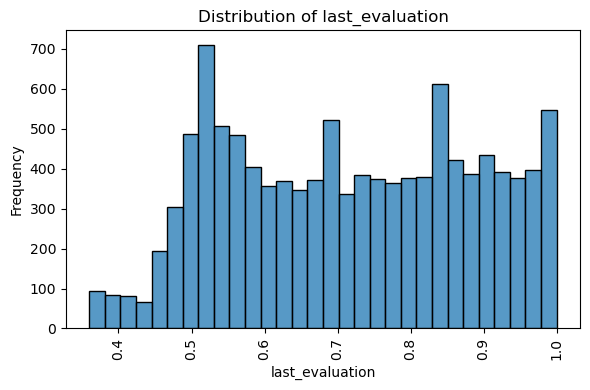

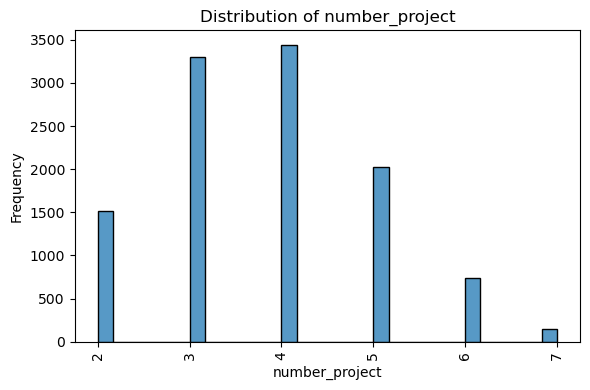

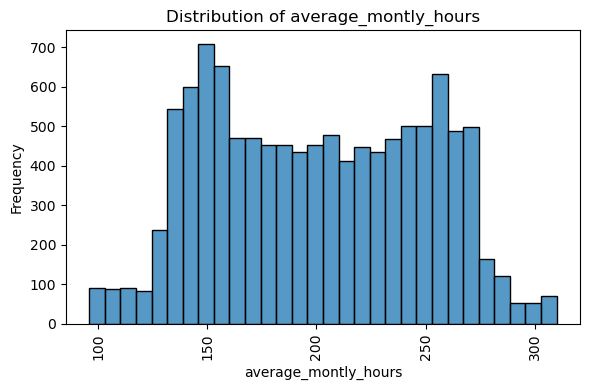

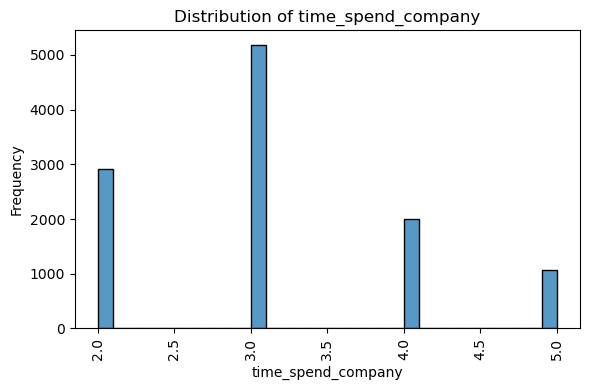

In [26]:
# We create histograms for each continuous variable
continuous_vars = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_cleaned[var], bins=30)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.xticks(rotation=90)
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(fig_dir / f'{var}_distribution.pdf')
    plt.show()

We observe that **average monthly hours** follow a roughly uniform distribution in the middle range, with noticeable drops at both the low and high ends.

The **number of projects** appears to follow a somewhat normal distribution, with a clear peak around **4 projects**.

**Last evaluation scores** show a relatively uniform distribution, with fewer employees receiving very low scores. This suggests that poor evaluations are rare, while most employees receive moderate to high scores.

The **satisfaction scores** display a similar pattern, but with a distinct **peak near zero**, indicating that a subset of employees report being highly unsatisfied.

We will explore these employees a bit further in a later step


Next we will do the same for categorical variables

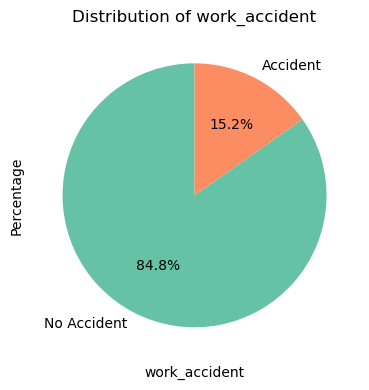

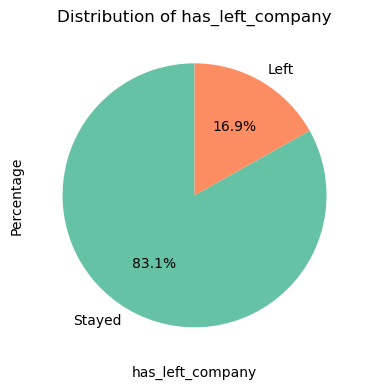

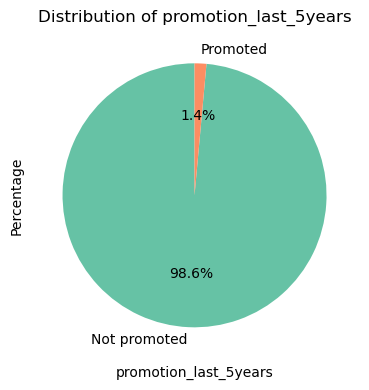

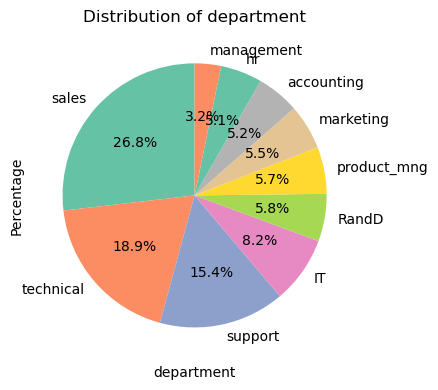

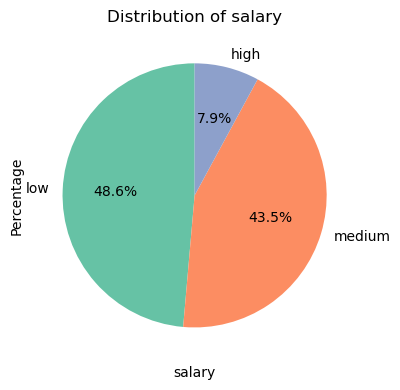

In [27]:
## Create plot for all categorical variables
categorical_vars = df_cleaned.select_dtypes(include=['object']).columns
for var in categorical_vars:
    plt.figure(figsize=(6, 4))
    # Make pie chart for categorical variables
    df_cleaned[var].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.xticks(rotation=90)
    plt.ylabel('Percentage')
    plt.tight_layout()
    plt.savefig(fig_dir / f'{var}_distribution.pdf')
    plt.show()

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/829289810.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=promotion_summary, x='department', y='promoted_pct', palette='Set2')


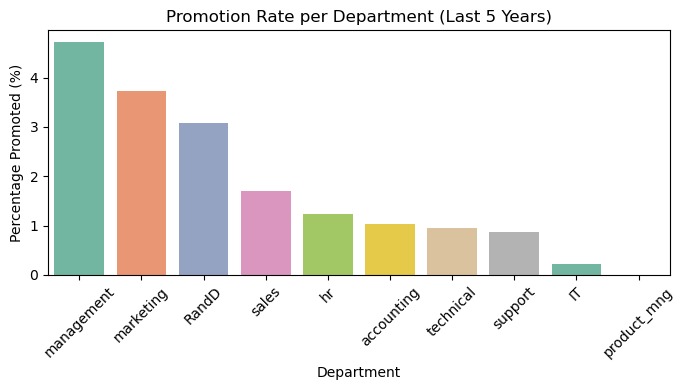

In [28]:
# Create a temporary binary series without changing the original dataframe
promotion_binary = df_cleaned['promotion_last_5years'].map({
    "Promoted": 1,
    "Not promoted": 0
}) if df_cleaned['promotion_last_5years'].dtype == object else df_cleaned['promotion_last_5years']

# Combine with department for groupby
temp_df = df_cleaned[['department']].copy()
temp_df['promotion_binary'] = promotion_binary 

# Group and compute stats
promotion_summary = (
    temp_df.groupby('department')
    .agg(
        n_total=('promotion_binary', 'count'),
        n_promoted=('promotion_binary', 'sum')
    )
    .assign(promoted_pct=lambda df: df['n_promoted'] / df['n_total'] * 100)
    .reset_index()
    .sort_values('promoted_pct', ascending=False)
)

plt.figure(figsize=(7, 4))
sns.barplot(data=promotion_summary, x='department', y='promoted_pct', palette='Set2')
plt.title('Promotion Rate per Department (Last 5 Years)')
plt.ylabel('Percentage Promoted (%)')
plt.xlabel('Department')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(fig_dir / 'promotion_percentage_by_department.pdf')
plt.show()

Besides noticing that **more than 10% of employees have experienced a workplace accident**, we observe that **only about 1% of employees have been promoted in the last 5 years**, suggesting that promotions are rare. Within this small group, the majority of promotions occurred in the **Management** and **Marketing** departments, followed by **R&D** and **Sales**. Departments such as **HR** and **Accounting** showed lower promotion rates.

Next we will look at the association of the categorical variables with the target variable `has_left_company`

  work_accident has_left_company  percentage
0      Accident             Left    5.934195
1   No Accident             Left   18.816693
2      Accident           Stayed   94.065805
3   No Accident           Stayed   81.183307


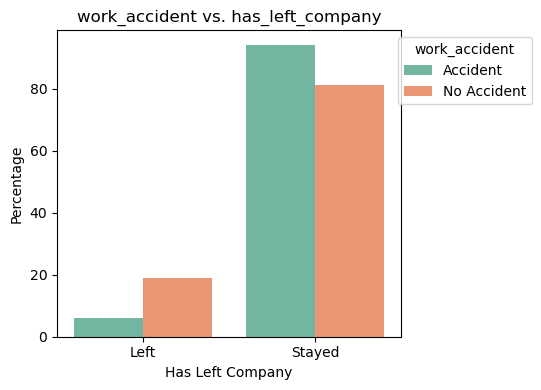

  promotion_last_5years has_left_company  percentage
0          Not promoted             Left   17.027076
1              Promoted             Left    4.968944
2          Not promoted           Stayed   82.972924
3              Promoted           Stayed   95.031056


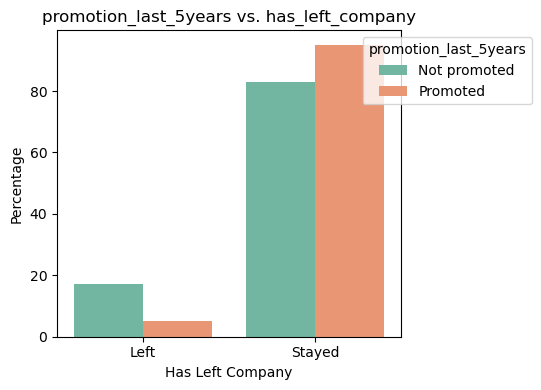

     department has_left_company  percentage
0            IT             Left   16.830601
1         RandD             Left   12.480740
2    accounting             Left   17.838765
3            hr             Left   18.947368
4    management             Left   13.888889
5     marketing             Left   16.531605
6   product_mng             Left   15.756630
7         sales             Left   17.617618
8       support             Left   16.676351
9     technical             Left   17.360454
10           IT           Stayed   83.169399
11        RandD           Stayed   87.519260
12   accounting           Stayed   82.161235
13           hr           Stayed   81.052632
14   management           Stayed   86.111111
15    marketing           Stayed   83.468395
16  product_mng           Stayed   84.243370
17        sales           Stayed   82.382382
18      support           Stayed   83.323649
19    technical           Stayed   82.639546


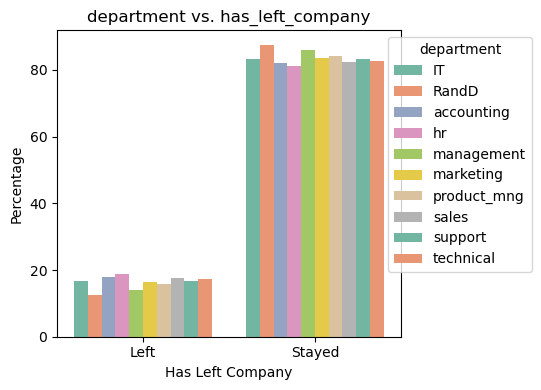

   salary has_left_company  percentage
0    high             Left    5.429864
1     low             Left   20.390495
2  medium             Left   14.977338
3    high           Stayed   94.570136
4     low           Stayed   79.609505
5  medium           Stayed   85.022662


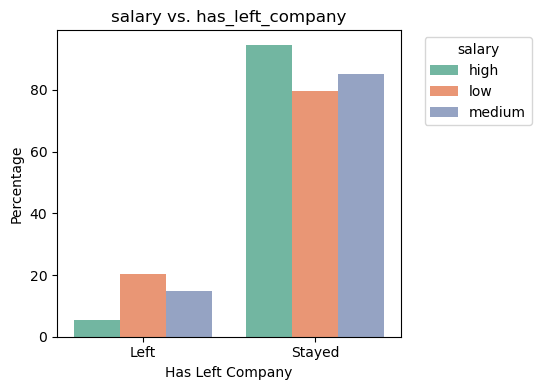

In [29]:
# Now we visualize the relationships between the target variable (has_left_company) and each of the categorical variables
for target_var in categorical_vars:
    if target_var != 'has_left_company':  # Avoid plotting the target variable against itself
        # Compute percentage of people who left vs. stayed for each category (group by target variable)
        category_percentages = df_cleaned.groupby(target_var)['has_left_company'].value_counts(normalize=True).unstack().fillna(0) * 100
        category_percentages = category_percentages.reset_index()
        # Pivot the DataFrame for easier plotting
        category_percentages = category_percentages.melt(id_vars=target_var, var_name='has_left_company', value_name='percentage')
        print(category_percentages)
        plt.figure(figsize=(6, 4))
        sns.barplot(data=category_percentages, x='has_left_company', y='percentage', hue=target_var, palette='Set2')
        plt.title(f'{target_var} vs. has_left_company')
        plt.xlabel('Has Left Company')
        plt.ylabel('Percentage')
        # Put legend outside the plot
        plt.legend(title=target_var, loc='upper right', bbox_to_anchor=(1.4, 1))
        plt.tight_layout()
        plt.savefig(fig_dir / f'{target_var}_vs_has_left_company.pdf')
        plt.show()

We do the same for the continuous variables

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/980083550.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_left_company', y=cont_var, data=df_cleaned, palette='Set2')


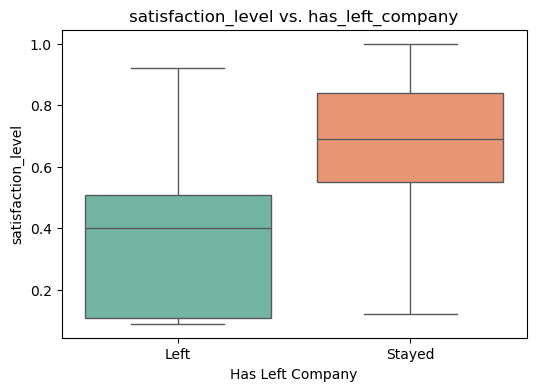

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/980083550.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_left_company', y=cont_var, data=df_cleaned, palette='Set2')


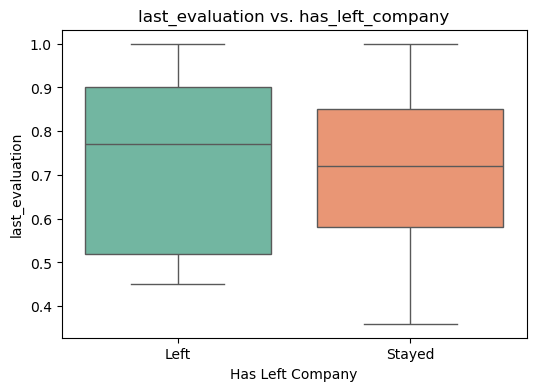

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/980083550.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_left_company', y=cont_var, data=df_cleaned, palette='Set2')


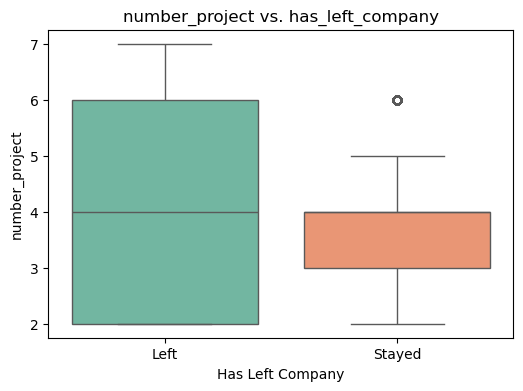

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/980083550.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_left_company', y=cont_var, data=df_cleaned, palette='Set2')


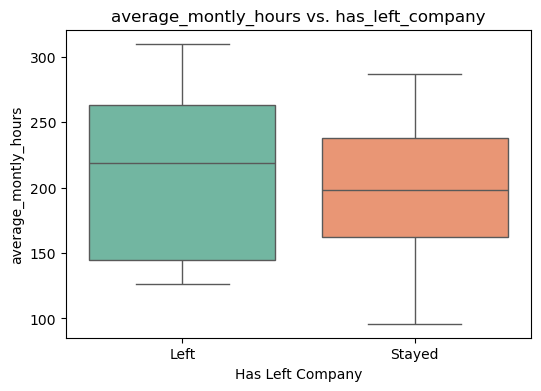

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/980083550.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='has_left_company', y=cont_var, data=df_cleaned, palette='Set2')


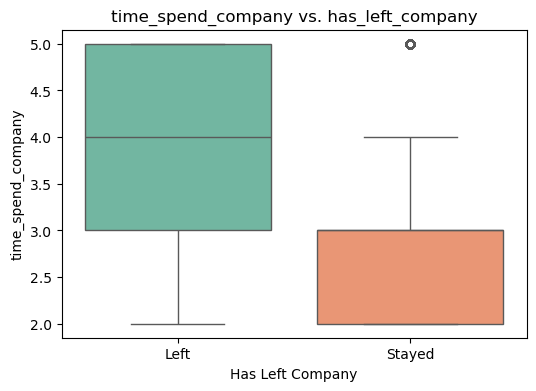

In [30]:
# Do the same for continuous variables
for cont_var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='has_left_company', y=cont_var, data=df_cleaned, palette='Set2')
    plt.title(f'{cont_var} vs. has_left_company')
    plt.xlabel('Has Left Company')
    plt.ylabel(cont_var)
    plt.tight_layout
    plt.savefig(fig_dir / f'{cont_var}_vs_has_left_company.pdf')
    plt.show()

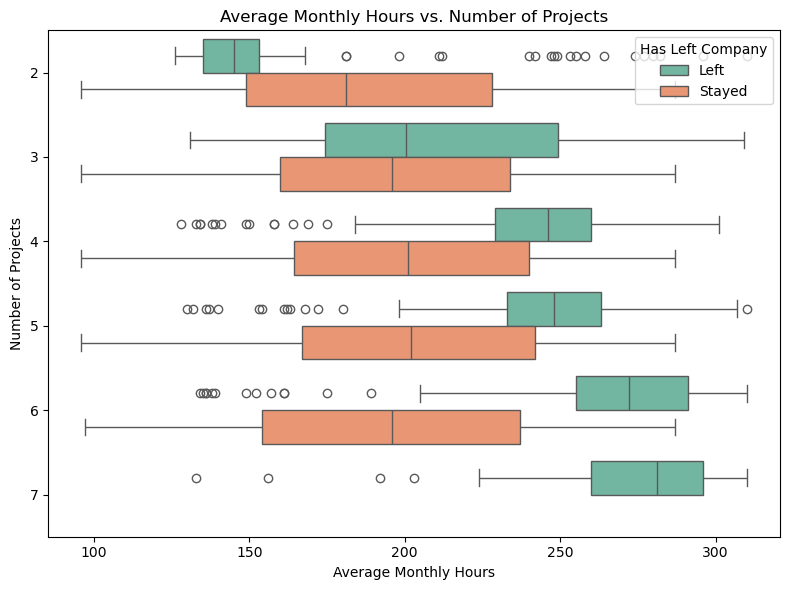

In [31]:
## Observing that employees who left the company seem to work more and had more projects, we will explore this relationship a bit more

# Create a grouped boxplot to visualize the relationship between average monthly hours and number of projects
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_cleaned, x='average_montly_hours', y='number_project', orient="h", hue='has_left_company', palette='Set2')
plt.title('Average Monthly Hours vs. Number of Projects')
plt.xlabel('Average Monthly Hours')
plt.ylabel('Number of Projects')
plt.legend(title='Has Left Company', loc='upper right') 
plt.tight_layout()
plt.savefig(fig_dir / 'average_monthly_hours_vs_number_project.pdf')
plt.show()


We observe several notable patterns in the data:

Employees who **left the company** show distinct differences compared to those who **stayed**:

- They worked **more monthly hours**, handled **more projects**, and received **higher evaluation scores**.
- They were **less likely to have been promoted** in the last 5 years.
- They tended to have **lower salaries**.
- Their **satisfaction levels were lower** on average.
- They also had **longer average tenure** with the company.

### Detailed Analysis of Employee Satisfaction

Given the previous observation of a **skewed satisfaction distribution**, with some employees reporting **very low satisfaction levels**, we now take a closer look at this group in more detail.


/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/1380906535.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=class_col)


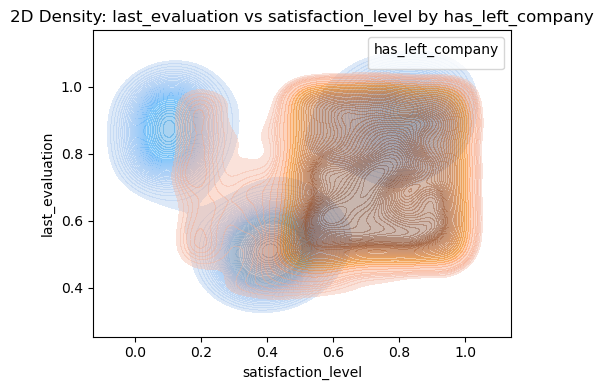

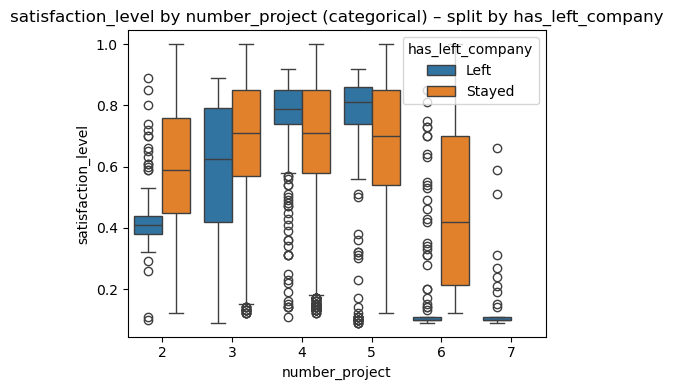

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/1380906535.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=class_col)


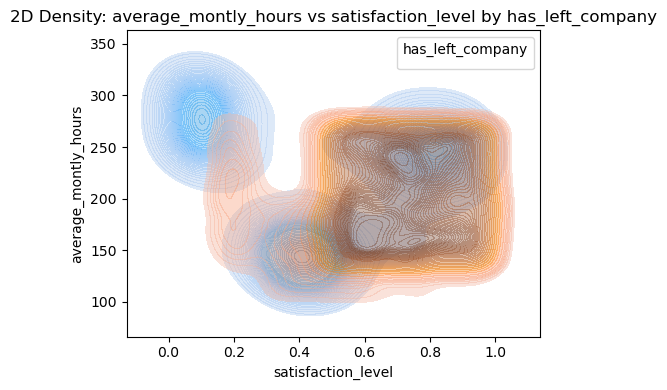

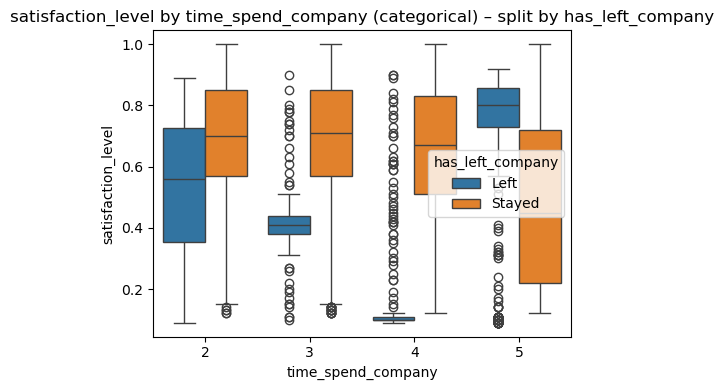

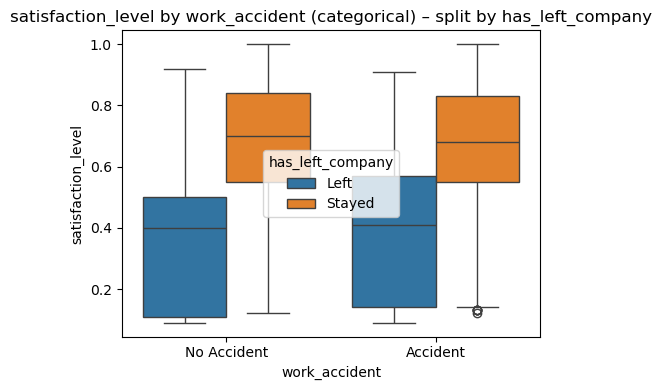

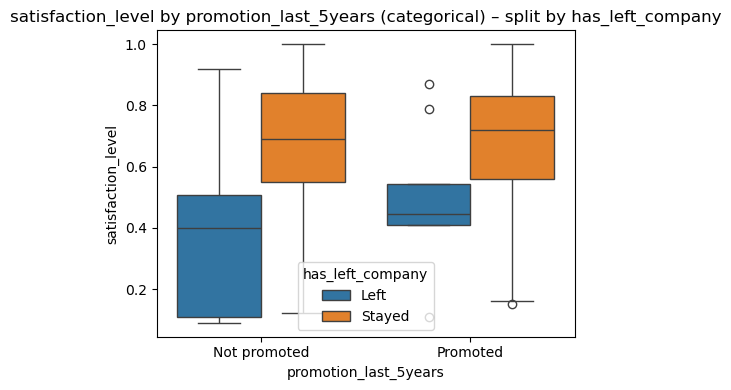

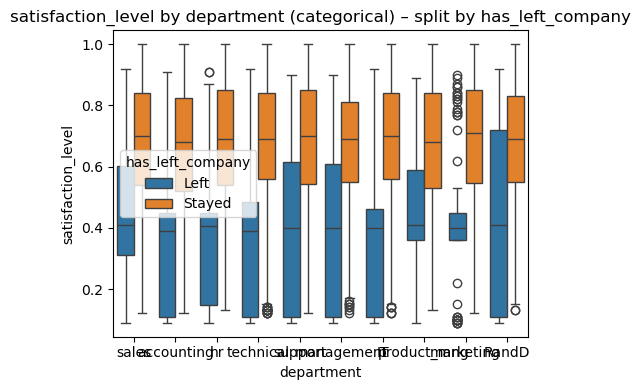

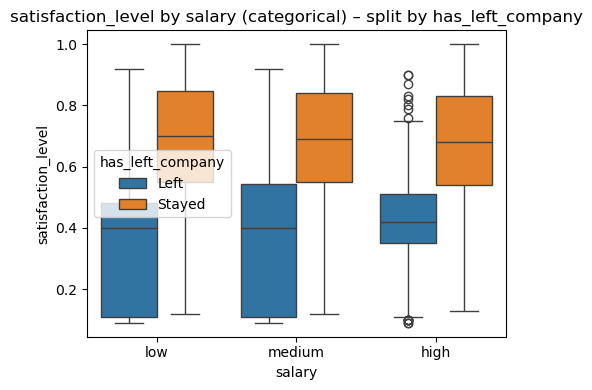

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

target = "satisfaction_level"
class_col = "has_left_company"

# Loop through all features except the target
for col in df_cleaned.columns:
    if col in [target, class_col] or df_cleaned[col].nunique() <= 1:
        continue

    plt.figure(figsize=(5, 4))

    # If column is numeric
    if pd.api.types.is_numeric_dtype(df_cleaned[col]):
        unique_vals = df_cleaned[col].nunique()

        if pd.api.types.is_integer_dtype(df_cleaned[col]) and unique_vals < 10:
            # Treat low-cardinality integers as categorical
            sns.boxplot(data=df_cleaned, x=col, y=target, hue=class_col)
            plt.title(f"{target} by {col} (categorical) – split by {class_col}")
        else:
            # 2D KDE plot for each class separately
            for cls in sorted(df_cleaned[class_col].dropna().unique()):
                subset = df_cleaned[df_cleaned[class_col] == cls]
                sns.kdeplot(
                    data=subset,
                    x=target,
                    y=col,
                    fill=True,
                    alpha=0.4,
                    levels=50,
                    label=f"{class_col} = {cls}"
                )

            plt.legend(title=class_col)
            plt.title(f"2D Density: {col} vs {target} by {class_col}")
    
    else:
        sns.boxplot(data=df_cleaned, x=col, y=target, hue=class_col)
        plt.title(f"{target} by {col} (categorical) – split by {class_col}")

    plt.tight_layout()
    plt.show()

We observe that satisfaction levels severely decline with increasing **number of projects**, especially for more than 5 projects.

#### Investigate accident by department

     department work_accident  percentage
0            IT      Accident   13.770492
1         RandD      Accident   16.949153
2    accounting      Accident   14.408233
3            hr      Accident   13.157895
4    management      Accident   15.000000
5     marketing      Accident   15.559157
6   product_mng      Accident   15.756630
7         sales      Accident   15.315315
8       support      Accident   15.979082
9     technical      Accident   15.231788
10           IT   No Accident   86.229508
11        RandD   No Accident   83.050847
12   accounting   No Accident   85.591767
13           hr   No Accident   86.842105
14   management   No Accident   85.000000
15    marketing   No Accident   84.440843
16  product_mng   No Accident   84.243370
17        sales   No Accident   84.684685
18      support   No Accident   84.020918
19    technical   No Accident   84.768212


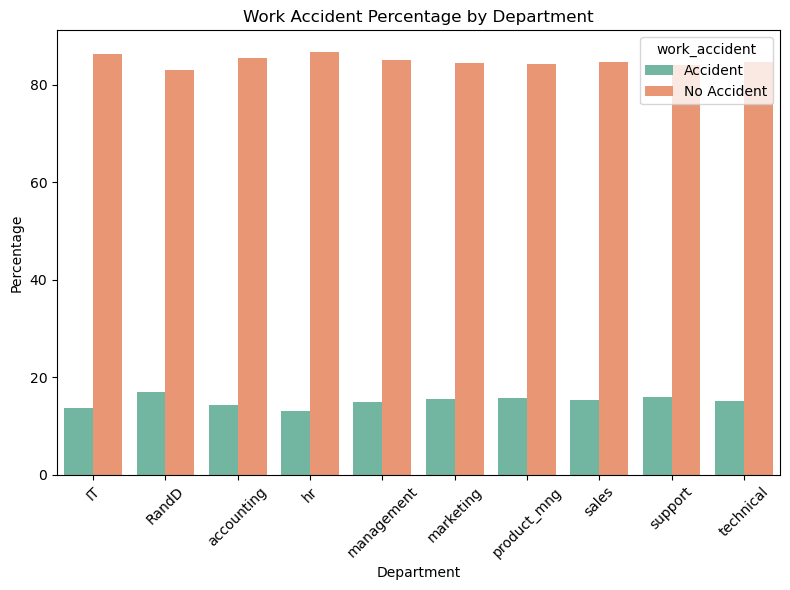

In [33]:
# Compute percentage of work accidents by department
work_accident_percentage = df_cleaned.groupby('department')['work_accident'].value_counts(normalize=True).unstack().fillna(0) * 100
work_accident_percentage = work_accident_percentage.reset_index()
work_accident_percentage = work_accident_percentage.melt(id_vars='department', var_name='work_accident', value_name='percentage')
print(work_accident_percentage)
plt.figure(figsize=(8, 6))
sns.barplot(data=work_accident_percentage, x='department', y='percentage', hue='work_accident', palette='Set2')
plt.title('Work Accident Percentage by Department')
plt.xlabel('Department')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(fig_dir / 'work_accident_percentage_by_department.pdf')

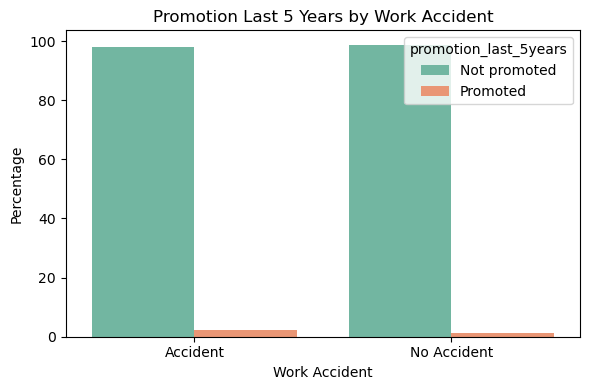

Chi² = 6.980, p = 0.0082


In [34]:
promotion_accident_percentage = (
    df_cleaned
    .groupby('work_accident')['promotion_last_5years']
    .value_counts(normalize=True)
    .rename('percentage')              # rename the Series to a column
    .mul(100)                          # scale to percent
    .unstack(fill_value=0)             # pivot promotion values into columns
    .reset_index()                     # flatten the index
    .melt(
        id_vars='work_accident',
        var_name='promotion_last_5years',
        value_name='percentage'
    )
)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=promotion_accident_percentage,
    x='work_accident',
    y='percentage',
    hue='promotion_last_5years',
    palette='Set2'
)
plt.title('Promotion Last 5 Years by Work Accident')
plt.xlabel('Work Accident')
plt.ylabel('Percentage')
plt.tight_layout()

# Save (assuming `fig_dir` is defined as Path object)
plt.savefig(fig_dir / 'promotion_last_5years_by_work_accident.pdf')
plt.show()

# Chi-squared test
contingency = pd.crosstab(df_cleaned['work_accident'], df_cleaned['promotion_last_5years'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi² = {chi2:.3f}, p = {p:.4f}")


We find that employees who have experienced a work accident are **significantly more likely to be promoted** in the last 5 years

### Assess multicollinearity in data

/var/folders/22/sjkvvcj17_gdnvz15k1nj1800000gn/T/ipykernel_87077/3904959028.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIF', y='Variable', data=vif.sort_values('VIF', ascending=False), palette='viridis')


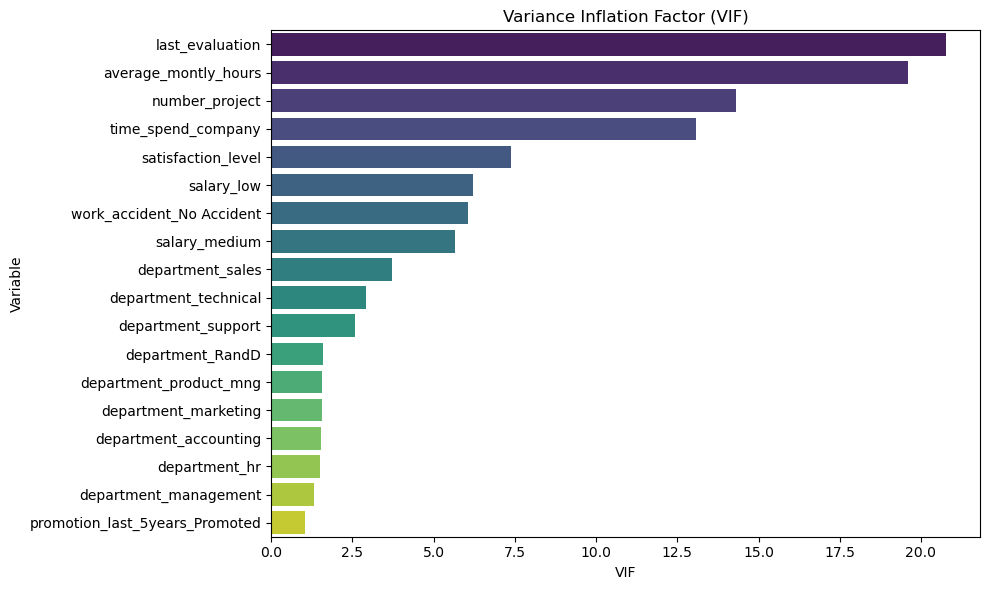

In [36]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Separate predictors from target
predictor_vars = df_cleaned.columns[df_cleaned.columns != 'has_left_company']

# One-hot encode categorical variables
X = pd.get_dummies(df_cleaned[predictor_vars], drop_first=True)

# Convert to float to avoid TypeError
X = X.astype(float)

# Compute VIF
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Plot VIF values sort from highest to lowest
plt.figure(figsize=(10, 6))
sns.barplot(x='VIF', y='Variable', data=vif.sort_values('VIF', ascending=False), palette='viridis')
plt.title('Variance Inflation Factor (VIF)')
plt.xlabel('VIF')
plt.ylabel('Variable')
plt.tight_layout()
plt.savefig(fig_dir / 'vif_plot.pdf')
plt.show()

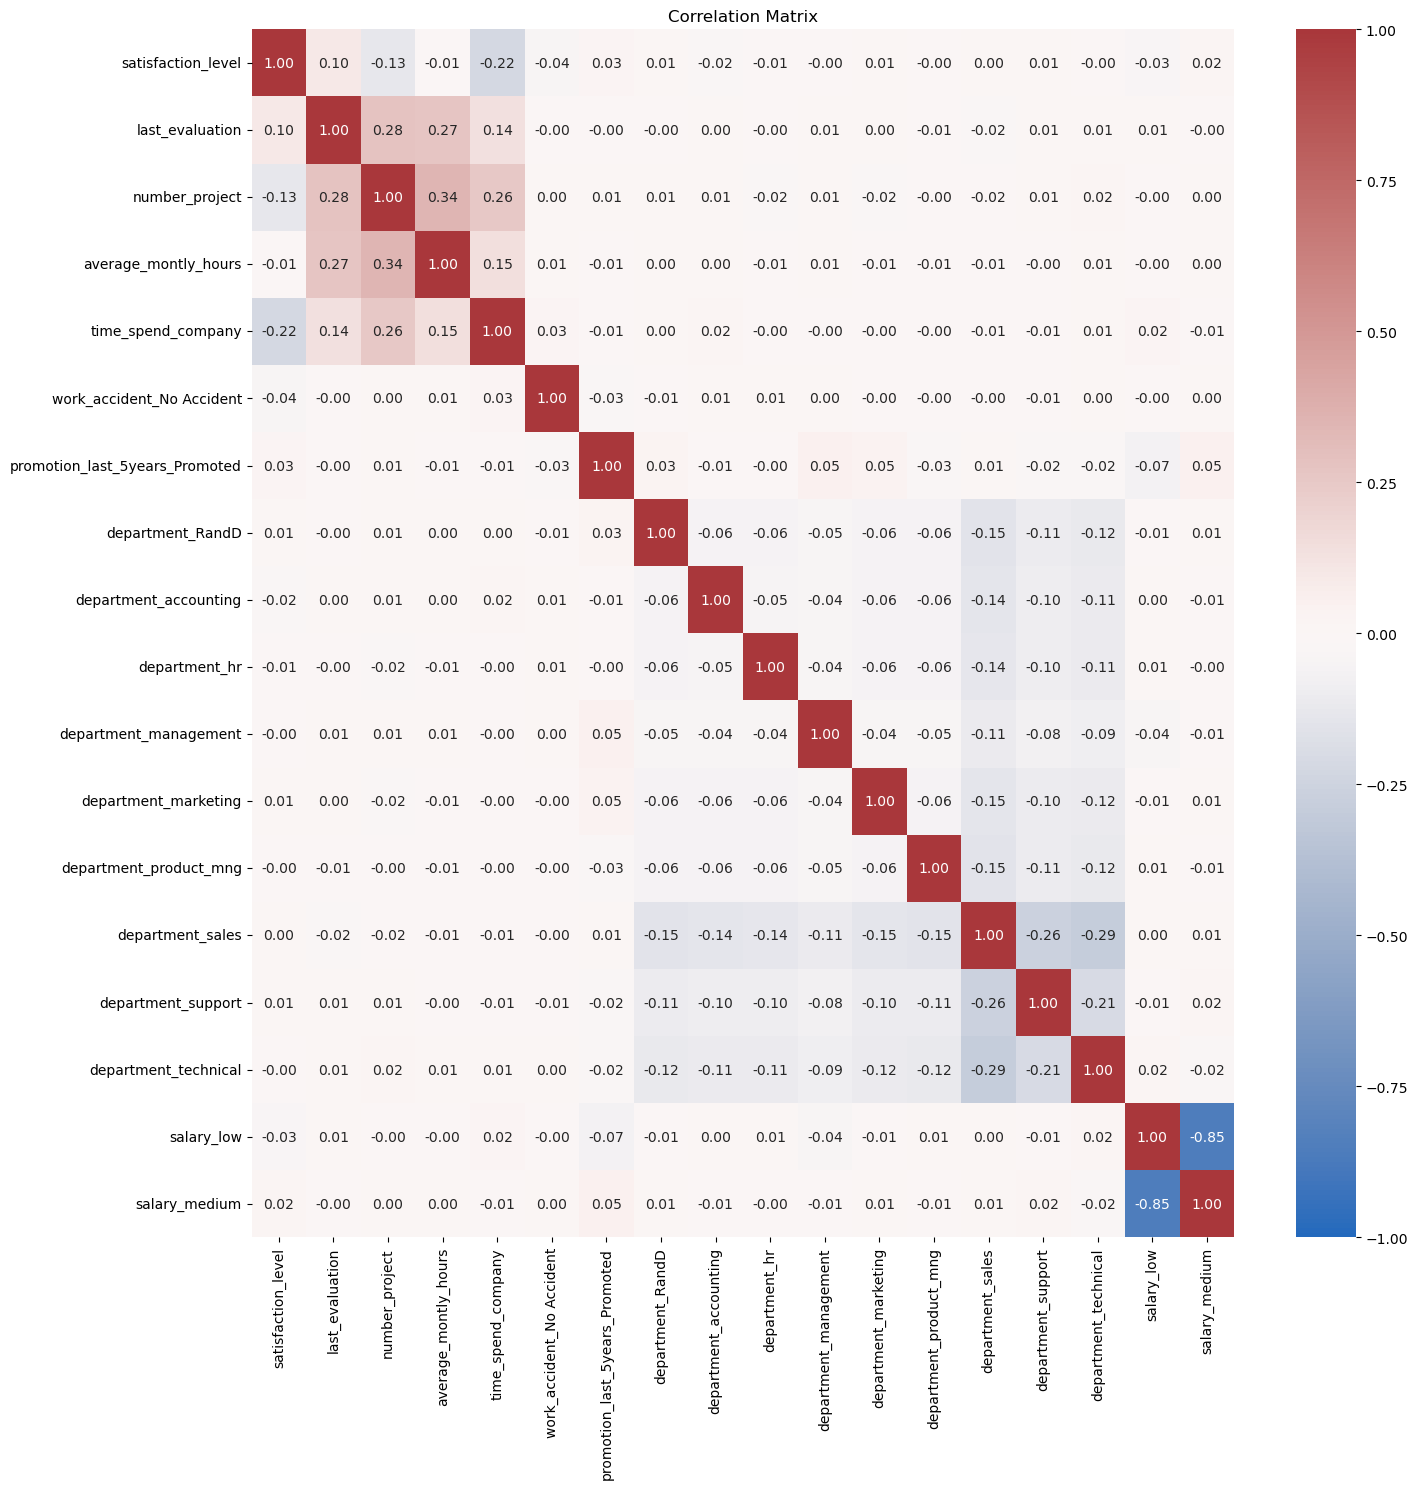

In [38]:
## Look at correlation matrix to assess multicollinearity
# Calculate the correlation matrix
correlation_matrix = X.corr()  
# Plot the correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title('Correlation Matrix')
plt.tight_layout()
plt.savefig(fig_dir / 'correlation_matrix.pdf')
plt.show()

In addition, we observe multicollinearity among the following variables:
- **last_evaluation**, **average_monthly_hours**, and **number_project** show strong positive correlations with each other.

Additionally, we note:
- A positive correlation between being in the **management** department and having been **promoted in the last 5 years**.

### Insights of EDA

Employees who left the company showed distinct patterns compared to those who stayed:

- **Workload & Performance**:
  - They had higher average monthly hours, more projects, and higher evaluation scores.

- **Career Progression**  
  - Less likely to have been promoted in the last 5 years  
  - Lower salaries  

- **Job Satisfaction & Tenure**  
  - Significantly lower satisfaction levels  
  - Spent more time with the company on average  

- **Department Trends**  
  - Slightly higher turnover in **support**, **accounting**, and **HR**  
  - Compared to slightly lower turnover in **R&D** and **management**  

- **Work Accidents**  
  - Small but significant effect: employees who had a work accident were **slightly more likely to be promoted**

Based on these findings, we can come up with a set of reasonable assumptions why these employees might have left:

1. Lack of Career Growth and Advancement:
Employees who were less likely to have been promoted in the last 5 years might have felt stagnant in their careers, leading to dissatisfaction and eventually leaving the company in search of better growth opportunities.

2. Work-Life Imbalance:
Higher average monthly hours and increased workload could have contributed to burnout, causing employees to leave for a better work-life balance or more manageable expectations elsewhere.

3. Lower Job Satisfaction:
The significantly lower satisfaction levels among those who left suggest that they might not have felt valued or engaged in their roles, prompting them to seek a more fulfilling job experience.

4. Inadequate Compensation:
Employees who earned lower salaries might have felt undervalued compared to their contributions, leading them to seek higher-paying opportunities outside the company.